# I. Flax implementation

In [ ]:
import jax
from jax import lax, random, numpy as jnp
# No function to convert PIL image to jax array : intermediary conversion to numpy array necessary
import numpy as np

import flax
from flax import struct, linen as nn
from flax.training import train_state
import optax
from clu import metrics

# No native dataloading mechanism in Jax
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from typing import Sequence
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# Globales
batch_size = 256
workers = 8
learning_rate = 0.001
epochs = 100
seed = 654321

## 1.1. Data preparation

In [ ]:
def flatten_transform(x):
    """ Scales values from [0, 255] to [0, 1] and flattens the 2D images (28x28 -> 784) """
    return np.ravel(np.array(x, dtype=jnp.float32) / 255.)

def numpy_collate(batch):
    """ Stack elements in batches of numpy arrays instead of Torch tensors """
    transposed_data = list(zip(*batch))
    imgs = np.stack(transposed_data[0])
    labels = np.array(transposed_data[1])

    return imgs, labels

In [ ]:
trainset = MNIST(root="./data", train=True, download=True, transform=flatten_transform)
testset = MNIST(root="./data", train=False, download=True, transform=flatten_transform)
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=workers, collate_fn=numpy_collate, drop_last=True)
testloader = DataLoader(testset, batch_size, shuffle=False, num_workers=workers, collate_fn=numpy_collate, drop_last=True)
len(trainset), len(testset)

(60000, 10000)

Display of the first 10 images of the trainloader (not the first 10 of the dataset since shuffle=True) to confirm that the loaders have been correctly created

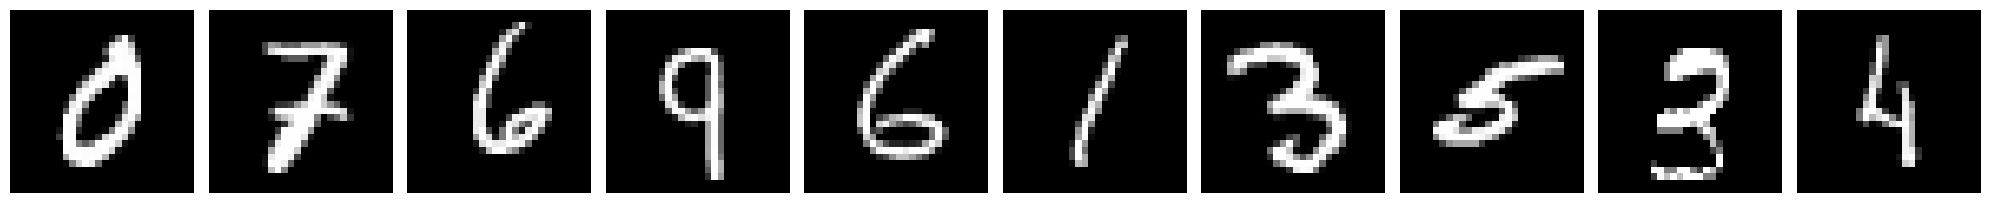

In [ ]:
# For the pytorch dataloader 
# https://discuss.pytorch.org/t/reproducibility-dataloader-shuffle-true-using-seeds/173836/2
torch.manual_seed(seed)
imgs, _ = next(iter(trainloader))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

## 1.2. Vanilla autoencoder

### 1.2.1. Model

In [ ]:
class Encoder(nn.Module):
    """ A simple MLP encoder """
    latents: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for i, n in enumerate(self.latents):
            x = nn.Dense(features=n)(x)
            if i != len(self.latents) - 1:
                x = nn.relu(x)
        return x

In [ ]:
class Decoder(nn.Module):
    """ A simple MLP decoder """
    latents: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for i, n in enumerate(self.latents):
            x = nn.Dense(features=n)(x)
            # No activation function for last layer
            # cf. use of sigmoid_binary_cross_entropy as loss function
            if i != len(self.latents) - 1:
                x = nn.relu(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    """ Full autoencoder model """
    latents: Sequence[int]

    def setup(self):
        self.encoder = Encoder(self.latents)
        self.decoder = Decoder(([784] + list(self.latents[:-1]))[::-1])

    def __call__(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Full model inspection

In [ ]:
autoencoder = Autoencoder([512, 128, 64])
print(autoencoder.tabulate(random.PRNGKey(seed), jnp.ones((1, 784))))


                              Autoencoder Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ Autoencoder │ float32[1,78… │ float32[1,784] │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ encoder       │ Encoder     │ float32[1,78… │ float32[1,64]  │               │
├───────────────┼─────────────┼───────────────┼────────────────┼───────────────┤
│ encoder/Dens… │ Dense       │ float32[1,78… │ float32[1,512] │ bias:         │
│               │             │               │                │ float32[512]  │
│               │             │               │                │ kernel:       │
│               │             │               │                │ float32[784,… │
│               │          

### 1.2.2. Training

In [ ]:
# https://flax.readthedocs.io/en/latest/getting_started.html#create-a-trainstate
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')


class TrainState(train_state.TrainState):
    metrics: Metrics


def create_train_state(model, rng, learning_rate):
    """ Instanciate the state outside of the training loop """
    params = model.init(rng, jnp.ones([1, 784]))['params']
    opti = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=opti,
        metrics=Metrics.empty())


@jax.jit
def train_step(state, batch):
    """ Train for a single step """
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch[0])
        loss = optax.sigmoid_binary_cross_entropy(
            logits=logits, labels=batch[0]).mean()
        return loss, logits
    
    # Update parameters with gradient descent
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    # Update loss, stored in the state object
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch[0], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state


@jax.jit
def eval_step(state, batch):
    """ Computes the metric on the test batch (code already included in train_step for train batch) """
    logits = state.apply_fn({'params': state.params}, batch[0])
    loss = optax.sigmoid_binary_cross_entropy(
        logits=logits, labels=batch[0]).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch[0], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
init_rng = random.PRNGKey(seed)
state = create_train_state(autoencoder, init_rng, learning_rate)
del init_rng

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    for batch in trainloader:
        state = train_step(state, batch)
    train_loss.append(state.metrics.compute()['loss'].item())
    # Reset train_metrics for next training epoch
    state = state.replace(metrics=state.metrics.empty())
    
    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        test_state = eval_step(test_state, batch)
    test_loss.append(test_state.metrics.compute()['loss'].item())
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 8s, sys: 36.9 s, total: 1min 45s
Wall time: 2min 13s


### 1.2.3. Results

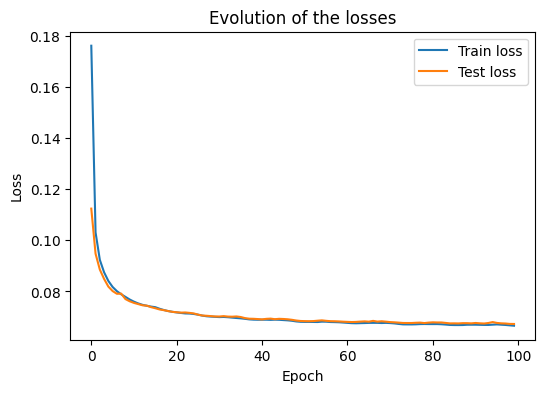

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(epochs), train_loss, label="Train loss")
plt.plot(np.arange(epochs), test_loss, label="Test loss")
plt.title("Evolution of the losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

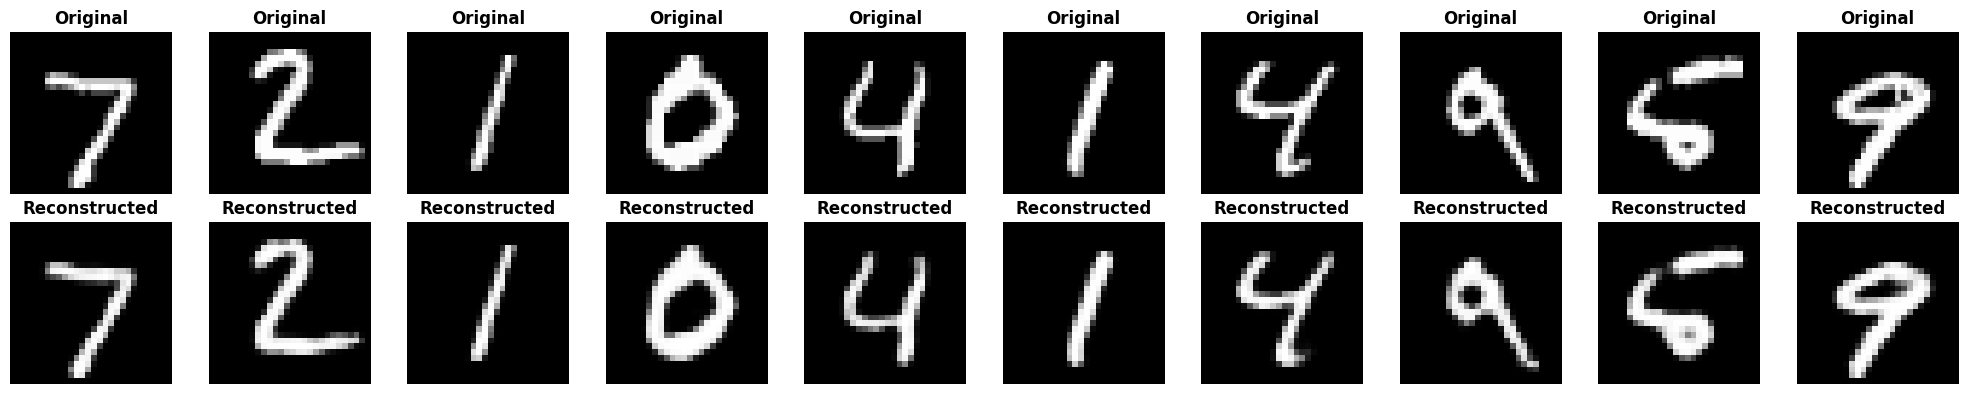

In [ ]:
imgs, _ = next(iter(testloader))
rec = nn.sigmoid(state.apply_fn({'params': state.params}, imgs))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = rec[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

The results are quite good, but the dataset is really simple (and the network is probably overparametrized for such an easy task). <br>
Let's set the latent space dimension to 2 to visualize the representations learned by the neural network. 

### 1.2.4. Latent space visualization

In [ ]:
autoencoder = Autoencoder([512, 128, 64, 2])
init_rng = random.PRNGKey(seed)
state = create_train_state(autoencoder, init_rng, learning_rate)
del init_rng

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    for batch in trainloader:
        state = train_step(state, batch)
    train_loss.append(state.metrics.compute()['loss'].item())
    # Reset train_metrics for next training epoch
    state = state.replace(metrics=state.metrics.empty())
    
    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        test_state = eval_step(test_state, batch)
    test_loss.append(test_state.metrics.compute()['loss'].item())
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 40.4 s, total: 2min
Wall time: 2min 20s


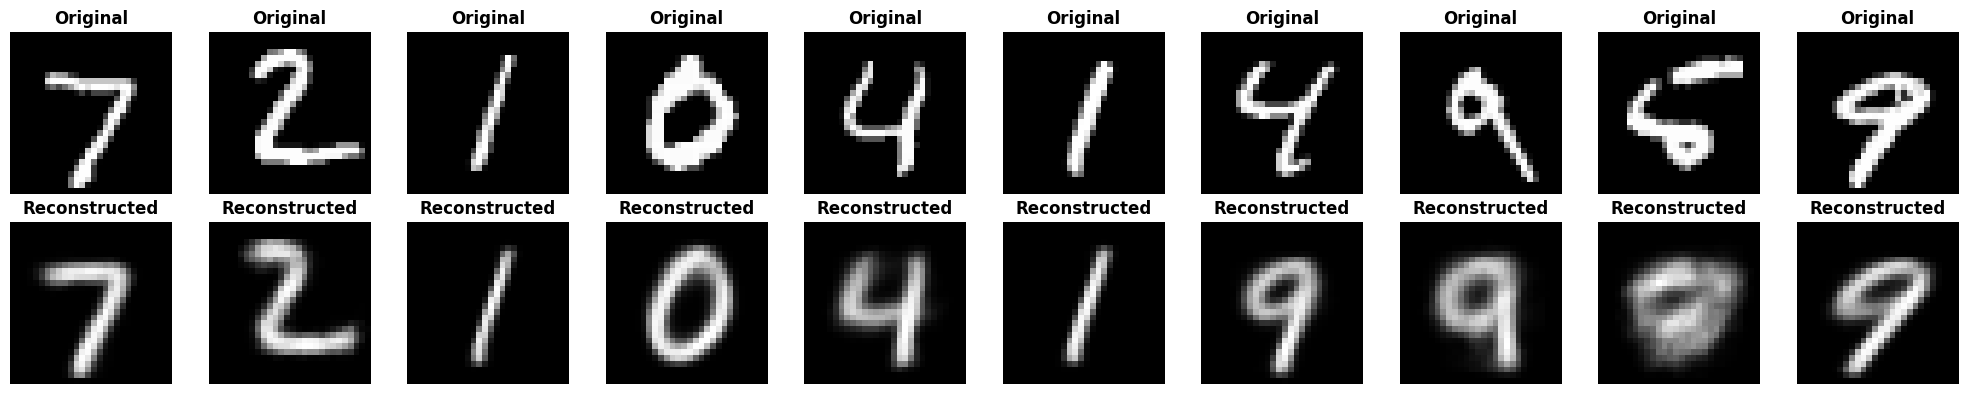

In [ ]:
imgs, _ = next(iter(testloader))
rec = nn.sigmoid(state.apply_fn({'params': state.params}, imgs))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = rec[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

As could be expected, the results are more blurry, but still decent for a model with only 2 neurons in the latent space !

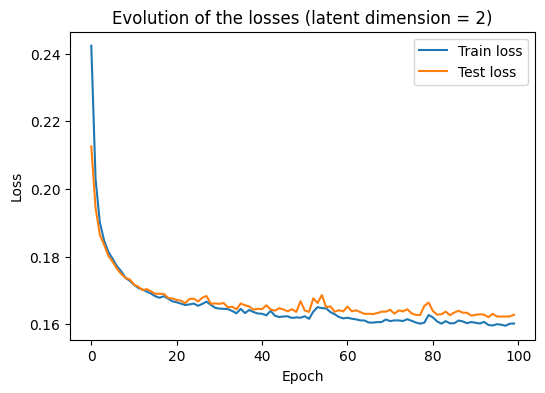

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(epochs), train_loss, label="Train loss")
plt.plot(np.arange(epochs), test_loss, label="Test loss")
plt.title("Evolution of the losses (latent dimension = 2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Encoding of the train set into latent space

In [ ]:
encoder = Encoder([512, 128, 64, 2])
init_rng = random.PRNGKey(seed)
enc_state = create_train_state(encoder, init_rng, learning_rate)
del init_rng

embeddings, labels = [], []
full_trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=workers, collate_fn=numpy_collate)
torch.manual_seed(seed)
for batch in full_trainloader:
    embeddings.append(enc_state.apply_fn({'params': state.params['encoder']}, batch[0]))
    labels.append(batch[1])
embeddings = jnp.vstack(embeddings)
labels = jnp.concatenate(labels)

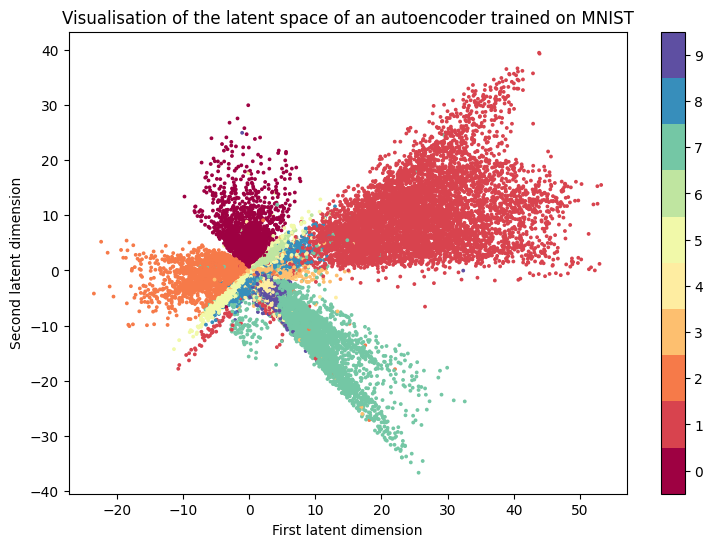

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral', s=3)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel("First latent dimension")
plt.ylabel("Second latent dimension")
plt.title('Visualisation of the latent space of an autoencoder trained on MNIST');

Without applying any constraint, we can still observe some form of clustering : most numbers are localized into a specific zone of the 2D latent space. This only works because MNIST is a relatively simple dataset, with low variance within each class. <br>
However, this representation helps understand the limitations of autoencoders as generative models :
 * The latent space is not continuous
 * The values on the different dimensions are not bounded  : scale between -30 and 60 along the first dimension, and between -40 and 40 for the second dimension
 
This makes it difficult to generate new data, as randomly sampling the latent space will most likely result in sampling from unmapped space, i.e. generating an image likely unrelated to the training set.

A few examples are shown below

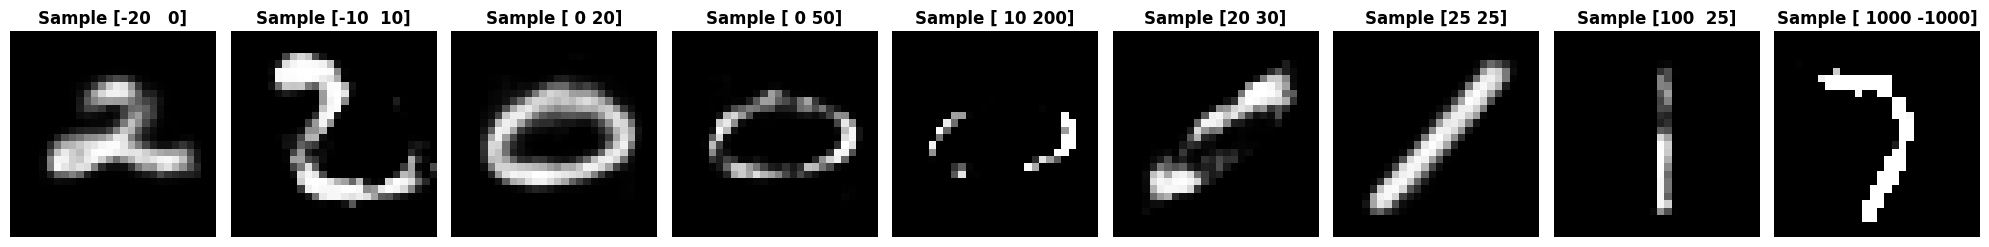

In [ ]:
decoder = Decoder([64, 128, 512, 784])
init_rng = random.PRNGKey(seed)
dec_state = create_train_state(decoder, init_rng, learning_rate)
del init_rng

samples = jnp.array([[-20, 0], [-10, 10], [0, 20], [0, 50], [10, 200], [20, 30], [25, 25], [100, 25], [1000, -1000]])
plt.figure(figsize=(20, 4))
for i, sample in enumerate(samples):
    ax = plt.subplot(1, samples.shape[0], i + 1)
    img = nn.sigmoid(dec_state.apply_fn({'params': state.params['decoder']}, sample))
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {sample}", fontweight="bold")
plt.tight_layout()

The dataset being rather simple, the generated images for coordinates outside of the learned ranges still produce somehow recognisable numbers.

## 1.3. VAE

### 1.3.1. Model

In [ ]:
class VEncoder(nn.Module):
    """ Encoder of the VAE """
    latents: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for n in self.latents[:-1]:
            x = nn.Dense(features=n)(x)
            x = nn.relu(x)
        mean_x = nn.Dense(self.latents[-1])(x)
        logvar_x = nn.Dense(self.latents[-1])(x)
        return mean_x, logvar_x


class VDecoder(nn.Module):
    """ Decoder of the VAE """
    latents: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for i, n in enumerate(self.latents):
            x = nn.Dense(features=n)(x)
            # No activation function for last layer
            # cf. use of sigmoid_binary_cross_entropy as loss function
            if i != len(self.latents) - 1:
                x = nn.relu(x)
        return x


def sample(rng, mean, logvar):
    """ Sample latent vector from mean and log variance """
    std = jnp.exp(0.5 * logvar) # 0.5 for root square, exp to cancel log
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std


class VAE(nn.Module):
    """ Full VAE model """
    latents: Sequence[int]

    def setup(self):
        self.encoder = VEncoder(self.latents)
        self.decoder = VDecoder(([784] + list(self.latents[:-1]))[::-1])

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = sample(z_rng, mean, logvar)
        x_prime = self.decoder(z)
        return self.decoder(z), mean, logvar

### 1.3.2. Training

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')


class TrainState(train_state.TrainState):
    metrics: Metrics


def create_train_state(model, rng, learning_rate, z_rng):
    """ Instanciate the state outside of the training loop """
    params = model.init(rng, jnp.ones([1, 784]), z_rng)['params']
    opti = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=opti,
        metrics=Metrics.empty())


def compute_loss(x, x_rec, mean, logvar):
    """ VAE loss is binary cross entropy (reconstruction loss) + KL divergence (regularization of latent space)"""
    bce = optax.sigmoid_binary_cross_entropy(logits=x_rec, labels=x).sum()
    kl = -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    return bce + kl


@jax.jit
def train_step(state, batch, z_rng):
    """ Train for a single step """
    def loss_fn(params):
        logits, mean, logvar = state.apply_fn({'params': params}, batch[0], z_rng)
        loss = compute_loss(batch[0], logits, mean, logvar)
        return loss, logits
    
    # Update parameters with gradient descent
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    # Update loss, stored in the state object
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch[0], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state


@jax.jit
def eval_step(state, batch, z_rng):
    """ Computes the metric on the test batch (code already included in train_step for train batch) """
    logits, mean, logvar = state.apply_fn({'params': state.params}, batch[0], z_rng)
    loss = compute_loss(batch[0], logits, mean, logvar)
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch[0], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
vae = VAE([512, 128, 64])
init_rng = random.PRNGKey(seed)
init_rng, z_init_rng, z_rng, eval_rng = random.split(init_rng, 4)
state = create_train_state(vae, init_rng, learning_rate, z_init_rng)

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    for batch in trainloader:
        z_rng, z_key = random.split(z_rng)
        state = train_step(state, batch, z_key)
    train_loss.append(state.metrics.compute()['loss'].item())
    # Reset train_metrics for next training epoch
    state = state.replace(metrics=state.metrics.empty())
    
    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        eval_rng, eval_key = random.split(eval_rng)
        test_state = eval_step(test_state, batch, eval_key)
    test_loss.append(test_state.metrics.compute()['loss'].item())
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 35s, sys: 49.3 s, total: 2min 24s
Wall time: 2min 33s


### 1.3.3. Results

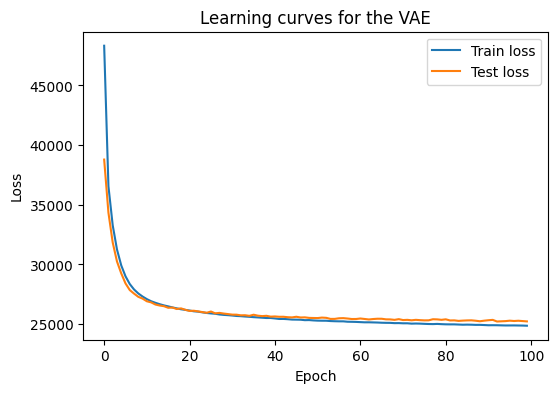

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(epochs), train_loss, label="Train loss")
plt.plot(np.arange(epochs), test_loss, label="Test loss")
plt.title("Learning curves for the VAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

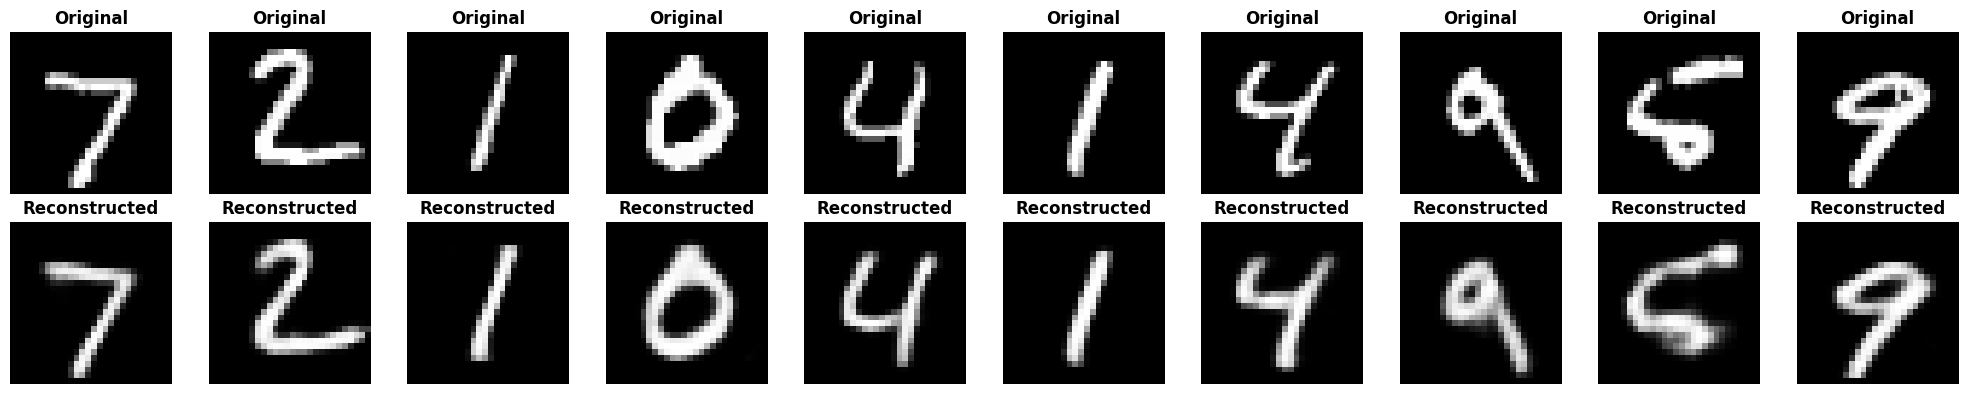

In [ ]:
imgs, _ = next(iter(testloader))
eval_rng, eval_key = random.split(eval_rng)
rec, _, _ = state.apply_fn({'params': state.params}, imgs, eval_key)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = nn.sigmoid(imgs[i]).reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = nn.sigmoid(rec[i]).reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

The quality of images obtained seems on par with the one of images generated with a vanilla autoencoder. The losses profile is also very similar.

### 1.3.4. Latent space visualization

In [ ]:
vae = VAE([512, 128, 64, 2])
init_rng = random.PRNGKey(seed)
init_rng, z_init_rng, z_rng, eval_rng = random.split(init_rng, 4)
state = create_train_state(vae, init_rng, learning_rate, z_init_rng)

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    for batch in trainloader:
        z_rng, z_key = random.split(z_rng)
        state = train_step(state, batch, z_key)
    train_loss.append(state.metrics.compute()['loss'].item())
    # Reset train_metrics for next training epoch
    state = state.replace(metrics=state.metrics.empty())
    
    # Compute metrics on the test set after each training epoch
    test_state = state
    for batch in testloader:
        eval_rng, eval_key = random.split(eval_rng)
        test_state = eval_step(test_state, batch, eval_key)
    test_loss.append(test_state.metrics.compute()['loss'].item())
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 43s, sys: 49.7 s, total: 2min 33s
Wall time: 2min 34s


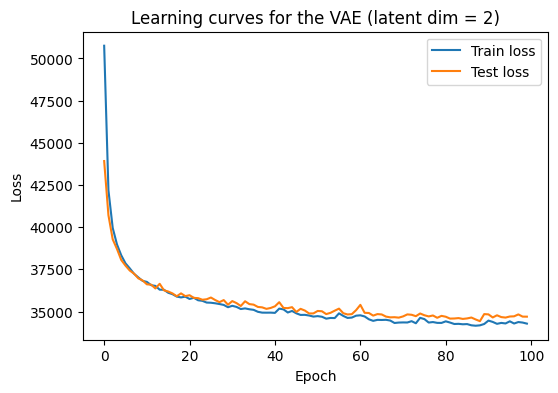

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(epochs), train_loss, label="Train loss")
plt.plot(np.arange(epochs), test_loss, label="Test loss")
plt.title("Learning curves for the VAE (latent dim = 2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

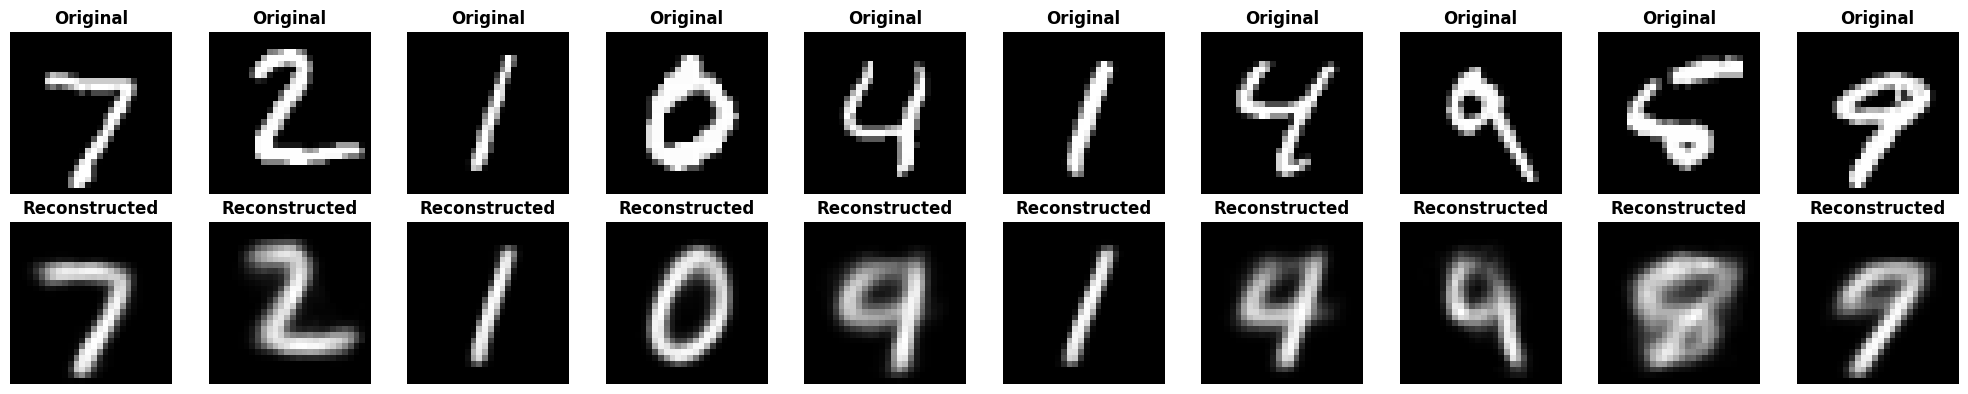

In [ ]:
imgs, _ = next(iter(testloader))
eval_rng, eval_key = random.split(eval_rng)
rec, _, _ = state.apply_fn({'params': state.params}, imgs, eval_key)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = nn.sigmoid(imgs[i]).reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = nn.sigmoid(rec[i]).reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

As with the vanilla autoencoder, images are blurrier but still decent.

In [ ]:
vencoder = VEncoder([512, 128, 64, 2])
venc_params = vencoder.init(init_rng, jnp.ones([1, 784]))['params']
opti = optax.adam(learning_rate)
venc_state = TrainState.create(apply_fn=vencoder.apply, params=venc_params,
                               tx=opti, metrics=Metrics.empty())

embeddings, labels = [], []
full_trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=workers, collate_fn=numpy_collate)
torch.manual_seed(seed)
for batch in full_trainloader:
    mean, logvar = venc_state.apply_fn({'params': state.params['encoder']}, batch[0])
    embeddings.append(mean)
    labels.append(batch[1])
embeddings = jnp.vstack(embeddings)
labels = jnp.concatenate(labels)

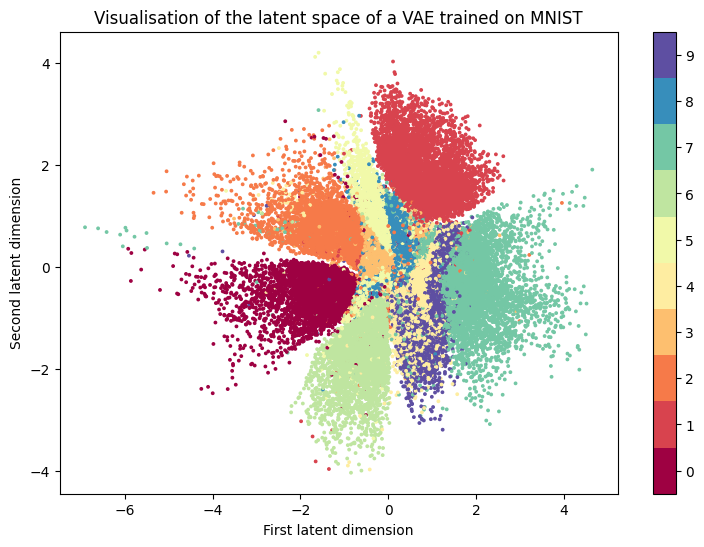

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral', s=3)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel("First latent dimension")
plt.ylabel("Second latent dimension")
plt.title('Visualisation of the latent space of a VAE trained on MNIST');

Since we are only plotting the coordinates of the mean, the differences constated here, in comparison to the latent space of the autoencoder, are only due to the influence of the KL term in the loss (same architecture and loss otherwise). <br>
Due to the KL, the clusters obtained are closer to a gaussian distribution of standard deviation 1. As a consequence, the points are less spread than for the vanilla autoencoder (dimension values between -4 and 4 this time) : the latent space is continuous in the center.

# II. PyTorch implementation

In order to compare the performances, the same models are implemented in PyTorch below.

In [ ]:
import torch
import torch.nn as nn # beware, same alias as flax.linen
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torchinfo import summary

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# Globales
batch_size = 256
workers = 8
learning_rate = 0.001
epochs = 100
seed = 654321
device = torch.device("cuda")
torch.cuda.manual_seed_all(seed)
torch.set_float32_matmul_precision('high')

In [ ]:
trainset = MNIST(root="./data", train=True, download=True,
                 transform=T.Compose([T.ToTensor(), torch.flatten]))
testset = MNIST(root="./data", train=False, download=True,
                transform=T.Compose([T.ToTensor(), torch.flatten]))
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=workers, drop_last=True)
testloader = DataLoader(testset, batch_size, shuffle=False, num_workers=workers, drop_last=True)
len(trainset), len(testset), len(trainloader), len(testloader)

(60000, 10000, 234, 39)

## 2.1. Vanilla autoencoder

### 2.1.1. Model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latents):
        """ Autoencoder constructor """
        super(Autoencoder, self).__init__()
        self.latents = [784] + latents
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        for i, l in enumerate(self.latents[:-1]):
            self.encoder.append(nn.Linear(l, self.latents[i+1]))
            if i != len(self.latents) - 2:
                x = nn.ReLU()
        for i, l in enumerate(self.latents[::-1][:-1]):
            self.decoder.append(nn.Linear(l, self.latents[::-1][i+1]))
            if i != len(self.latents) - 2:
                x = nn.ReLU()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
autoencoder = Autoencoder([512, 128, 64]).to(device)
autoencoder = torch.compile(autoencoder)
optim = torch.optim.Adam(autoencoder.parameters())
summary(autoencoder)

Layer (type:depth-idx)                   Param #
OptimizedModule                          --
├─Autoencoder: 1-1                       --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  401,920
│    │    └─Linear: 3-2                  65,664
│    │    └─Linear: 3-3                  8,256
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-4                  8,320
│    │    └─Linear: 3-5                  66,048
│    │    └─Linear: 3-6                  402,192
Total params: 952,400
Trainable params: 952,400
Non-trainable params: 0

Same number of parameters as for the Flax implementation

### 2.1.2. Training

In [ ]:
@torch.compile
def compute_loss(model,  batch):
    x = batch[0].to(device)
    x_prime = model(x)
    loss = F.binary_cross_entropy_with_logits(x_prime, x)
    return loss

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    step_loss = 0
    for batch in trainloader:
        optim.zero_grad()
        loss = compute_loss(autoencoder,  batch)
        step_loss += loss.item()
        loss.backward()
        optim.step()
    train_loss.append(step_loss / len(trainloader))
    
    step_loss = 0
    with torch.no_grad():
        for batch in testloader:
            step_loss += compute_loss(autoencoder,  batch).item()
        test_loss.append(step_loss / len(testloader))
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

[2023-09-15 22:44:59,656] torch._inductor.utils: [WARNING] DeviceCopy in input program


CPU times: user 2min 30s, sys: 1min 8s, total: 3min 38s
Wall time: 4min 2s


### 2.1.3. Results

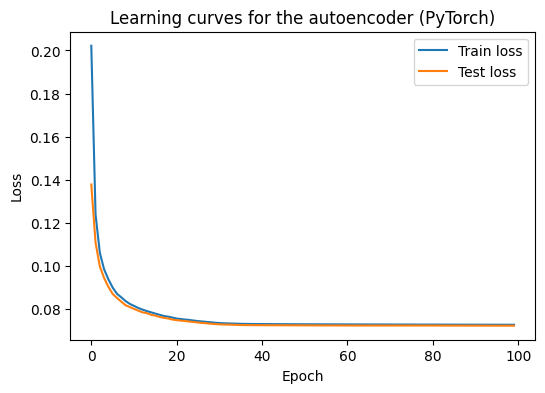

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(torch.arange(epochs), train_loss, label="Train loss")
plt.plot(torch.arange(epochs), test_loss, label="Test loss")
plt.title("Learning curves for the autoencoder (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

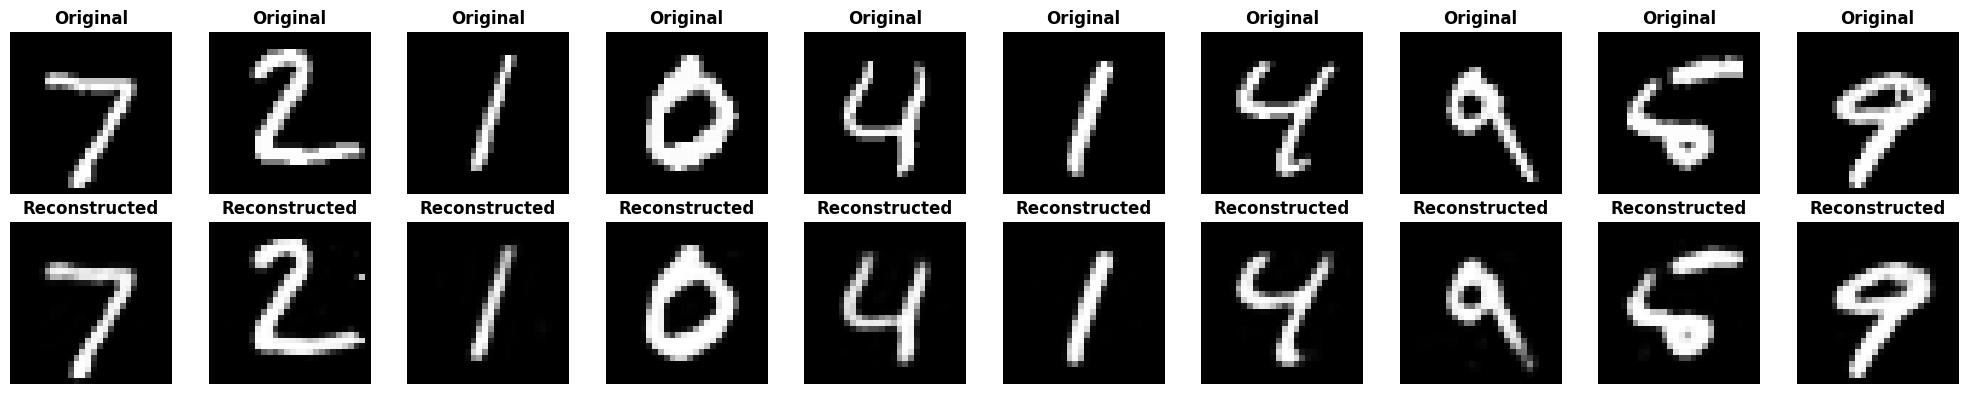

In [ ]:
imgs, _ = next(iter(testloader))
rec = F.sigmoid(autoencoder(imgs.to(device))).cpu().detach().numpy()
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = rec[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

The results are quite similar to the ones obtained with Flax both in terms of loss values and reconstructed images (apart from the noticeable white dot observed on the second image reconstructed). However, the training time is quite higher with PyTorch, even after compiling the model and trying to jit the loss computation.

<ins>Training wall time</ins> :

|   | Autoencodeur | VAE |
|:-:|:-:|:-:|
| Flax | <font color='LimeGreen'><b>2min 13s</b></font> | 2min 33s |
| PyTorch | 4min 2s |   |


## 2.2. VAE

### 2.2.1. Model

In [ ]:
class VAE(nn.Module):
    def __init__(self, latents):
        """ Autoencoder constructor """
        super(VAE, self).__init__()
        self.latents = [784] + latents
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        for i, l in enumerate(self.latents[:-2]):
            self.encoder.append(nn.Linear(l, self.latents[i+1]))
            self.encoder.append(nn.ReLU())
        for i, l in enumerate(self.latents[::-1][:-1]):
            self.decoder.append(nn.Linear(l, self.latents[::-1][i+1]))
            if i != len(self.latents) - 2:
                self.decoder.append(nn.ReLU())
        self.mean = nn.Linear(self.latents[-2], self.latents[-1])
        self.logvar = nn.Linear(self.latents[-2], self.latents[-1])
                   
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.sample(mean, logvar)
        return self.decoder(z), mean, logvar
    
    def sample(self, mean, logvar):
        """ Sample latent vector from mean and log variance """
        std = torch.exp(0.5*logvar)  # 0.5 for root square, exp to cancel log
        epsilon = torch.randn_like(std)
        return mean + std * epsilon

In [ ]:
vae = VAE([512, 128, 64]).to(device)
vae = torch.compile(vae)
optim = torch.optim.Adam(vae.parameters())

### 2.2.2. Training

In [ ]:
@torch.compile
def compute_loss(model,  batch):
    x = batch[0].to(device)
    x_prime, mean, logvar = model(x)
    cross_entropy = F.binary_cross_entropy_with_logits(x_prime, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return cross_entropy + kl

In [ ]:
%%time
epoch = tqdm(range(epochs))
train_loss, test_loss = [], []
for e in epoch:
    torch.manual_seed(seed)
    step_loss = 0
    for batch in trainloader:
        optim.zero_grad()
        loss = compute_loss(vae,  batch)
        step_loss += loss.item()
        loss.backward()
        optim.step()
    train_loss.append(step_loss / len(trainloader))
    
    step_loss = 0
    with torch.no_grad():
        for batch in testloader:
            step_loss += compute_loss(vae,  batch).item()
        test_loss.append(step_loss / len(testloader))
    epoch.set_description(f"Epoch: {e+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Test loss: {test_loss[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

[2023-09-15 23:42:23,518] torch._inductor.utils: [WARNING] DeviceCopy in input program
[2023-09-15 23:42:23,847] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


CPU times: user 2min 37s, sys: 1min 4s, total: 3min 42s
Wall time: 4min


### 2.2.3 Results

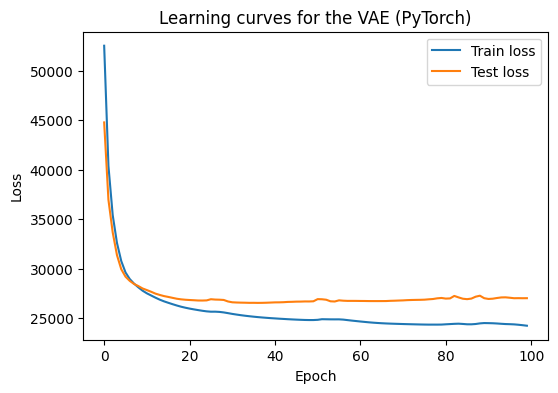

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(torch.arange(epochs), train_loss, label="Train loss")
plt.plot(torch.arange(epochs), test_loss, label="Test loss")
plt.title("Learning curves for the VAE (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

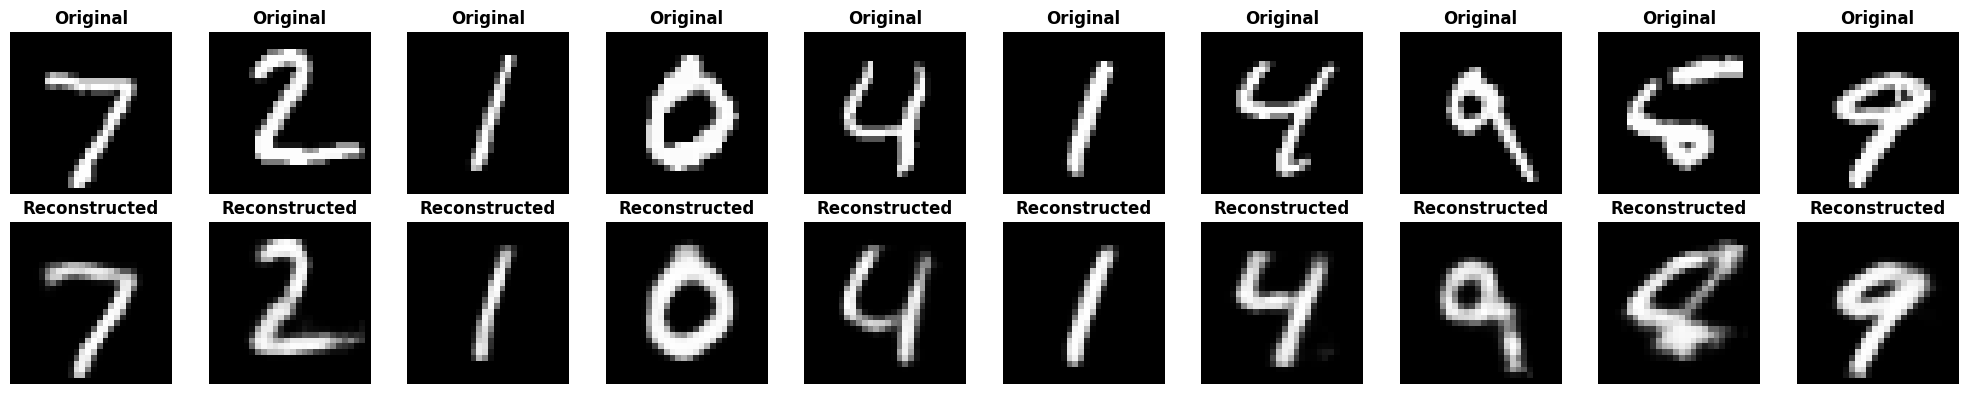

In [ ]:
imgs, _ = next(iter(testloader))
rec, _, _ = vae(imgs.to(device))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    img = imgs[i].reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original", fontweight="bold")
    ax = plt.subplot(2, 10, i + 11)
    img = F.sigmoid(rec[i]).cpu().detach().numpy().reshape((28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title("Reconstructed", fontweight="bold")
plt.tight_layout()

Once again, the images generated look quite similar to the ones obtained with Flax (the last `5` may be a bit worse). However, the learning curves seem to illustrate overfitting from around epoch 20 (even if the values obtained from the training loss are coherent with the ones obtained with Flax). <br>
As for training time, Flax is definitely faster. The GPU used was a `NVIDIA GeForce RTX 3060 Laptop GPU` (6 Go)

<ins>Training wall time</ins> :

|   | Autoencodeur | VAE |
|:-:|:-:|:-:|
| Flax | <font color='LimeGreen'><b>2min 13s</b></font> | <font color='LimeGreen'><b>2min 33s</b></font> |
| PyTorch | 4min 2s | 4min |